sources:

https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images?resource=download

https://medium.com/@vineethrajesh2/loading-in-your-own-image-datasets-in-pytorch-9e4064171074

In [1]:
# warm up

import torch
import time

# Ensure CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dummy input and model
dummy_input = torch.randn(64, 3, 224, 224).to(device)  # Adjust shape as needed
model = torch.nn.Conv2d(3, 64, kernel_size=3, padding=1).to(device)

# Warm-up loop
model.eval()
with torch.no_grad():
    for _ in range(10):  # 5–10 iterations usually enough
        _ = model(dummy_input)
        torch.cuda.synchronize()  # Ensures all CUDA ops are finished

# Optional: Wait briefly
time.sleep(1)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #literally only used for the lineplot? surely plt can do that too
from tqdm import tqdm

import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F #difference between that and torch.relu or torch.nn.Module.maxpool2d etc?

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [6]:
#transforms
train_transforms = transforms.Compose([
    transforms.ToTensor(), #can also do some resizing and normalizing
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #mean and std for normalization
	transforms.RandomHorizontalFlip(), #randomly flip the image horizontally
])

test_transforms = transforms.Compose([
    transforms.ToTensor(), #can also do some resizing and normalizing
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
#load actual data
train_data = ImageFolder("./data/train_subset", transform=train_transforms)
test_data = ImageFolder("./data/test_subset", transform=test_transforms)

#dataloaders
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4) #num_workers is for loading data in parallel ..?
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [8]:
#check how many images in the dataset
print(len(train_data)) #100k
print(len(test_data)) #20k

#check the classes
print(type(train_data)) #torchvision.datasets.folder.ImageFolder
# print(train_data.classes) #0 is fake and 1 is real
# print(test_data.classes)

#check the shape of the images
print(train_data[0][0].shape) #3 channels, 32 x 32 px
print(train_data[0]) #0 or 1, fake or real

4000
800
<class 'torchvision.datasets.folder.ImageFolder'>
torch.Size([3, 32, 32])
(tensor([[[0.3373, 0.3216, 0.3294,  ..., 0.3922, 0.3804, 0.3608],
         [0.3333, 0.3333, 0.3529,  ..., 0.4078, 0.3765, 0.3529],
         [0.3490, 0.3608, 0.3922,  ..., 0.4078, 0.3843, 0.3647],
         ...,
         [0.2667, 0.2549, 0.2549,  ..., 0.2941, 0.2902, 0.2863],
         [0.2824, 0.2667, 0.2549,  ..., 0.2824, 0.2667, 0.2549],
         [0.2784, 0.2588, 0.2431,  ..., 0.2196, 0.2000, 0.1843]],

        [[0.2588, 0.2431, 0.2431,  ..., 0.3529, 0.3216, 0.2941],
         [0.2549, 0.2549, 0.2667,  ..., 0.3686, 0.3176, 0.2941],
         [0.2627, 0.2745, 0.3020,  ..., 0.3765, 0.3333, 0.3137],
         ...,
         [0.1882, 0.1804, 0.1686,  ..., 0.1961, 0.1922, 0.1843],
         [0.2157, 0.2000, 0.1804,  ..., 0.1922, 0.1765, 0.1647],
         [0.2157, 0.1961, 0.1725,  ..., 0.1294, 0.1098, 0.0941]],

        [[0.2235, 0.2000, 0.2000,  ..., 0.2157, 0.2000, 0.1765],
         [0.2118, 0.2118, 0.2157,  ...,

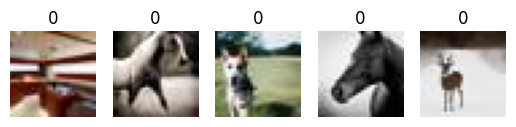

In [9]:
#print n images in train_data starting from starting_index
n_images = 5
starting_index=6
for i in range(n_images):
	plt.subplot(1, 5, i + 1) #subplot with 1 row and 5 columns
	plt.imshow(train_data[starting_index + i][0].permute(1, 2, 0)) #permute to get channels last
	plt.title(train_data[starting_index + i][1]) #show the label of the image, 0 is the index of the image
	plt.axis('off') #remove axis
plt.show()

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
#initialize model
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
# move model to device if applicable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
n_epochs = 10

In [14]:
#training loop
def train_cnn(model: nn.Module, train_loader, test_loader, epochs: int = 1000):
	print(f"Training on {device}")
	# Convert everything to tensors first
	loss_ls = []
	accuracy_ls = []
	model = model.to(device)

	for epoch in tqdm(range(epochs)):
		model.train()
		for features, target in train_loader:
			features, target = features.to(device), target.to(device)	
			optimizer.zero_grad()
			outputs = model(features)
			loss = criterion(outputs, target)
			loss.backward()
			optimizer.step()

		model.eval()
		with torch.no_grad():
			total_loss = 0
			combined = []
			for features, target in test_loader:
				features, target = features.to(device), target.to(device)
				output = model(features)
				loss = criterion(output, target)
				total_loss += loss.item()
				label_out = torch.argmax(output, dim=1) #argmax returns the index of the maximum value in the tensor
				combined.append((label_out, target))
				
			accuracy = [accuracy_score(c[0].cpu().numpy(), c[1].cpu().numpy()) for c in combined]
			loss_ls.append(total_loss / len(test_loader))
			accuracy_ls.append(np.mean(accuracy))
			print(f"Epoch {epoch + 1} - Loss: {total_loss / len(test_loader)} - Accuracy: {np.mean(accuracy)}")
	return loss_ls, accuracy_ls

In [15]:
loss_ls, accuracy_ls = train_cnn(model, train_loader, test_loader, epochs=50)

Training on cuda


  2%|▏         | 1/50 [00:57<47:14, 57.85s/it]

Epoch 1 - Loss: 0.6974094339779445 - Accuracy: 0.46763392857142855


  4%|▍         | 2/50 [01:41<39:47, 49.75s/it]

Epoch 2 - Loss: 0.6906975678035191 - Accuracy: 0.5535714285714286


  6%|▌         | 3/50 [02:27<37:21, 47.69s/it]

Epoch 3 - Loss: 0.6801113060542515 - Accuracy: 0.5892857142857143


  8%|▊         | 4/50 [03:12<35:45, 46.65s/it]

Epoch 4 - Loss: 0.6789680293628148 - Accuracy: 0.5569196428571429


 10%|█         | 5/50 [03:58<34:58, 46.63s/it]

Epoch 5 - Loss: 0.6122691929340363 - Accuracy: 0.6662946428571429


 12%|█▏        | 6/50 [04:45<34:09, 46.57s/it]

Epoch 6 - Loss: 0.6033304844583783 - Accuracy: 0.7053571428571429


 14%|█▍        | 7/50 [05:32<33:30, 46.76s/it]

Epoch 7 - Loss: 0.6131537641797747 - Accuracy: 0.6595982142857143


 16%|█▌        | 8/50 [06:21<33:18, 47.58s/it]

Epoch 8 - Loss: 0.5545415495123182 - Accuracy: 0.71875


 18%|█▊        | 9/50 [07:08<32:15, 47.20s/it]

Epoch 9 - Loss: 0.5481041286672864 - Accuracy: 0.7232142857142857


 20%|██        | 10/50 [07:54<31:13, 46.83s/it]

Epoch 10 - Loss: 0.5301747492381504 - Accuracy: 0.7399553571428571


 22%|██▏       | 11/50 [08:41<30:33, 47.02s/it]

Epoch 11 - Loss: 0.5324565895966121 - Accuracy: 0.7466517857142857


 24%|██▍       | 12/50 [09:27<29:37, 46.77s/it]

Epoch 12 - Loss: 0.5246559338910239 - Accuracy: 0.7477678571428571


 26%|██▌       | 13/50 [10:14<28:45, 46.63s/it]

Epoch 13 - Loss: 0.5398799989904676 - Accuracy: 0.734375


 28%|██▊       | 14/50 [11:00<28:00, 46.69s/it]

Epoch 14 - Loss: 0.5170086537088666 - Accuracy: 0.7477678571428571


 30%|███       | 15/50 [11:46<27:05, 46.43s/it]

Epoch 15 - Loss: 0.5162506358964103 - Accuracy: 0.7633928571428571


 32%|███▏      | 16/50 [12:32<26:13, 46.27s/it]

Epoch 16 - Loss: 0.500250552381788 - Accuracy: 0.7700892857142857


 34%|███▍      | 17/50 [13:18<25:21, 46.12s/it]

Epoch 17 - Loss: 0.5436292333262307 - Accuracy: 0.7354910714285714


 36%|███▌      | 18/50 [14:03<24:24, 45.75s/it]

Epoch 18 - Loss: 0.5006659967558724 - Accuracy: 0.7700892857142857


 38%|███▊      | 19/50 [14:49<23:40, 45.81s/it]

Epoch 19 - Loss: 0.4945072616849627 - Accuracy: 0.7723214285714286


 40%|████      | 20/50 [15:35<22:59, 46.00s/it]

Epoch 20 - Loss: 0.4798121622630528 - Accuracy: 0.78125


 42%|████▏     | 21/50 [16:18<21:43, 44.96s/it]

Epoch 21 - Loss: 0.4780766453061785 - Accuracy: 0.7879464285714286


 44%|████▍     | 22/50 [17:00<20:34, 44.11s/it]

Epoch 22 - Loss: 0.466452100447246 - Accuracy: 0.7901785714285714


 46%|████▌     | 23/50 [17:42<19:37, 43.59s/it]

Epoch 23 - Loss: 0.4669559044497354 - Accuracy: 0.8024553571428571


 48%|████▊     | 24/50 [18:24<18:42, 43.17s/it]

Epoch 24 - Loss: 0.4702080615929195 - Accuracy: 0.7790178571428571


 50%|█████     | 25/50 [19:07<17:51, 42.86s/it]

Epoch 25 - Loss: 0.4553049887929644 - Accuracy: 0.796875


 52%|█████▏    | 26/50 [19:50<17:11, 42.99s/it]

Epoch 26 - Loss: 0.4997548375810896 - Accuracy: 0.765625


 54%|█████▍    | 27/50 [20:32<16:23, 42.75s/it]

Epoch 27 - Loss: 0.438812004668372 - Accuracy: 0.8069196428571429


 56%|█████▌    | 28/50 [21:15<15:39, 42.71s/it]

Epoch 28 - Loss: 0.4672301028456007 - Accuracy: 0.7845982142857143


 58%|█████▊    | 29/50 [21:57<14:54, 42.60s/it]

Epoch 29 - Loss: 0.4313215953963144 - Accuracy: 0.7991071428571429


 60%|██████    | 30/50 [22:39<14:09, 42.49s/it]

Epoch 30 - Loss: 0.4399631938764027 - Accuracy: 0.7979910714285714


 62%|██████▏   | 31/50 [23:22<13:29, 42.61s/it]

Epoch 31 - Loss: 0.4236845374107361 - Accuracy: 0.8091517857142857


 64%|██████▍   | 32/50 [24:04<12:44, 42.48s/it]

Epoch 32 - Loss: 0.4135333810533796 - Accuracy: 0.8180803571428571


 66%|██████▌   | 33/50 [24:47<12:00, 42.39s/it]

Epoch 33 - Loss: 0.4077804684638977 - Accuracy: 0.8270089285714286


 68%|██████▊   | 34/50 [25:29<11:16, 42.29s/it]

Epoch 34 - Loss: 0.427192570907729 - Accuracy: 0.8013392857142857


 70%|███████   | 35/50 [32:27<38:46, 155.12s/it]

Epoch 35 - Loss: 0.4032287895679474 - Accuracy: 0.8147321428571429


 72%|███████▏  | 36/50 [33:10<28:20, 121.45s/it]

Epoch 36 - Loss: 0.42757546263081686 - Accuracy: 0.8013392857142857


 74%|███████▍  | 37/50 [33:53<21:13, 97.96s/it] 

Epoch 37 - Loss: 0.37964275905064176 - Accuracy: 0.8359375


 76%|███████▌  | 38/50 [34:36<16:18, 81.54s/it]

Epoch 38 - Loss: 0.38154856647763935 - Accuracy: 0.8303571428571429


 78%|███████▊  | 39/50 [35:19<12:50, 70.03s/it]

Epoch 39 - Loss: 0.36756340094975065 - Accuracy: 0.8381696428571429


 80%|████████  | 40/50 [36:03<10:21, 62.17s/it]

Epoch 40 - Loss: 0.36975494027137756 - Accuracy: 0.8493303571428571


 82%|████████▏ | 41/50 [36:47<08:28, 56.53s/it]

Epoch 41 - Loss: 0.4049544015101024 - Accuracy: 0.8180803571428571


 84%|████████▍ | 42/50 [37:30<07:00, 52.51s/it]

Epoch 42 - Loss: 0.41559661499091555 - Accuracy: 0.8035714285714286


 86%|████████▌ | 43/50 [38:13<05:47, 49.64s/it]

Epoch 43 - Loss: 0.3523992768355778 - Accuracy: 0.8426339285714286


 88%|████████▊ | 44/50 [38:56<04:45, 47.64s/it]

Epoch 44 - Loss: 0.3604641727038792 - Accuracy: 0.8392857142857143


 90%|█████████ | 45/50 [39:40<03:52, 46.57s/it]

Epoch 45 - Loss: 0.3539882940905435 - Accuracy: 0.8426339285714286


 92%|█████████▏| 46/50 [40:25<03:05, 46.28s/it]

Epoch 46 - Loss: 0.36597644218376707 - Accuracy: 0.8415178571428571


 94%|█████████▍| 47/50 [41:08<02:16, 45.35s/it]

Epoch 47 - Loss: 0.40124736726284027 - Accuracy: 0.8158482142857143


 96%|█████████▌| 48/50 [41:52<01:29, 44.76s/it]

Epoch 48 - Loss: 0.38983417195933207 - Accuracy: 0.8292410714285714


 98%|█████████▊| 49/50 [42:35<00:44, 44.37s/it]

Epoch 49 - Loss: 0.35906052376542774 - Accuracy: 0.8303571428571429


100%|██████████| 50/50 [43:19<00:00, 51.98s/it]

Epoch 50 - Loss: 0.3464109109980719 - Accuracy: 0.8448660714285714


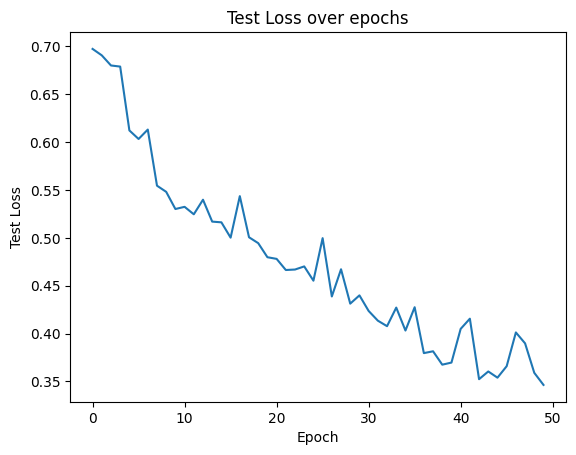

In [16]:
sns.lineplot(loss_ls)
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss over epochs")
plt.show();

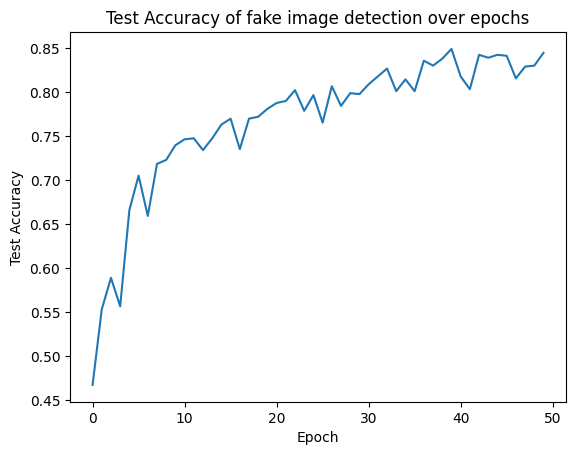

In [18]:
#test accuracy
sns.lineplot(accuracy_ls)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy of fake image detection over epochs")
plt.show();

In [ ]:
#plot f1 score over training?